In [25]:
import control
import matplotlib.pyplot as plt
import numpy as np

import vishack
import kontrol

seis_data1 = vishack.data.diaggui.Diaggui("../data/quiet_20240222.xml")
seis_data2 = vishack.data.diaggui.Diaggui("../data/quiet_20230720.xml")
seis_data3 = vishack.data.diaggui.Diaggui("../data/lockloss_20240101.xml")
seis_data4 = vishack.data.diaggui.Diaggui("../data/lockloss_20240107.xml")
seis_data5 = vishack.data.diaggui.Diaggui("../data/lockloss_20240112.xml")

In [218]:
f, seis_x1 = seis_data1.psd("L1:ISI-GND_STS_ITMX_X_DQ")
_, seis_x2 = seis_data2.psd("L1:ISI-GND_STS_ITMX_X_DQ")
_, seis_x3 = seis_data3.psd("L1:ISI-GND_STS_ITMX_X_DQ")
_, seis_x4 = seis_data4.psd("L1:ISI-GND_STS_ITMX_X_DQ")
_, seis_x5 = seis_data5.psd("L1:ISI-GND_STS_ITMX_X_DQ")

_, gs13_x1 = seis_data1.psd("L1:ISI-ITMX_ST2_BLND_X_GS13_CUR_IN1_DQ")


# Calibrate to m
seis_x1 = seis_x1 * 1/(2*np.pi*f) * 1e-9  # Integrate and nm to m
seis_x2 = seis_x2 * 1/(2*np.pi*f) * 1e-9
seis_x3 = seis_x3 * 1/(2*np.pi*f) * 1e-9
seis_x4 = seis_x4 * 1/(2*np.pi*f) * 1e-9
seis_x5 = seis_x5 * 1/(2*np.pi*f) * 1e-9

s = control.tf("s")
wn = 1*2*np.pi
q = 1/np.sqrt(2)
gs13_cal = (s**2 + wn/q*s + wn**2) / (s**3)

gs13_x1 = gs13_x1 * abs(gs13_cal(1j*2*np.pi*f)) * 1e-9

In [219]:
h_sc = kontrol.load_transfer_function("../filters/CML_BB_SC.pkl")
h1 = kontrol.load_transfer_function("../filters/102mHzv2_disp.pkl")
h2 = kontrol.load_transfer_function("../filters/102mHzv2_inert.pkl")

# Undo calibration coupling in the filter
h_sc = h_sc * s  # undo integrator
h2 = h2/gs13_cal  # undo gs13 calibration filter

In [76]:
def noise_model(f, na, nb, a, b):
    noise = ((na/f**a)**2+(nb/f**b)**2)**.5
    return noise

n_seis_params2 = [1*10**-9.9, 0, 2.5, 0]
n_seis_params1 = [1*10**-9.15, 0, 2.5, 0]
n_seis_params4 = [1*10**-9.8, 0, 2.5, 0]

In [150]:
gs13_noise_data = [ 670, 6.32e-5, 2.138e-8, 1.958e-9, 1.892e-10, 1.732e-11,
                    7.262e-12, 3.887e-12, 2.449e-12, 1.462e-12, 9.725e-13, 
                    4.423e-13, 3.280e-13, 1.137e-13, 5.610e-14, 2.053e-14,
                    2e-15]   
gs13_freq_data = [1e-4, 0.01, 0.101, 0.201, 0.400, 0.792, 0.994, 1.258, 1.655, 2.588, 
                 3.954, 8.202, 10.710, 24.796, 46.087, 91.208, 1e3]

ade1_freq_data   = [.001,  .002,  .01,    .1,    .7,    100]
ade1_noise_data  = [ 5e-8, 9e-9, 2.5e-9, 5e-10, 2e-10, 2e-10]

n_gs13_params = [1*10**-11.125, 1*10**-11.375, 3.5, 1.15]
n_ade1_params = [1*10**-10.0625, 2e-10, 0.75, 0]

n_seis1 = lambda f: noise_model(f, *n_seis_params1)
n_seis2 = lambda f: noise_model(f, *n_seis_params2)
n_seis4 = lambda f: noise_model(f, *n_seis_params4)

n_gs13 = lambda f: noise_model(f, *n_gs13_params)
n_ade1 = lambda f: noise_model(f, *n_ade1_params)

In [151]:
xg1 = np.array(seis_x1)
xg1[f<0.09] = xg1[f>=0.09][0] 

xg2 = np.array(seis_x2)
xg2[f<0.08] = xg2[f>=0.08][0] 

xg4 = np.array(seis_x4)
xg4[f<0.03] = xg4[f>=0.03][0] 

In [183]:
n_seis_filtered1 = abs(h_sc(1j*2*np.pi*f)) * n_seis1(f)
n_seis_filtered2 = abs(h_sc(1j*2*np.pi*f)) * n_seis2(f)
n_seis_filtered4 = abs(h_sc(1j*2*np.pi*f)) * n_seis4(f)

xg_filtered1 = abs((1-h_sc)(1j*2*np.pi*f)) * xg1
xg_filtered2 = abs((1-h_sc)(1j*2*np.pi*f)) * xg2
xg_filtered4 = abs((1-h_sc)(1j*2*np.pi*f)) * xg4

n_sc1 = kontrol.core.math.quad_sum(n_seis_filtered1, xg_filtered1)
n_sc2 = kontrol.core.math.quad_sum(n_seis_filtered2, xg_filtered2)
n_sc4 = kontrol.core.math.quad_sum(n_seis_filtered4, xg_filtered4)

n_rel_sc1 = kontrol.core.math.quad_sum(n_ade1(f), n_sc1)
n_rel_sc2 = kontrol.core.math.quad_sum(n_ade1(f), n_sc2)
n_rel_sc4 = kontrol.core.math.quad_sum(n_ade1(f), n_sc4)

n_rel_filtered1 = abs(h1(1j*2*np.pi*f)) * n_rel_sc1
n_rel_filtered2 = abs(h1(1j*2*np.pi*f)) * n_rel_sc2
n_rel_filtered4 = abs(h1(1j*2*np.pi*f)) * n_rel_sc4

n_gs13_filtered1 = abs(h2(1j*2*np.pi*f)) * n_gs13(f)
n_gs13_filtered2 = abs(h2(1j*2*np.pi*f)) * n_gs13(f)
n_gs13_filtered4 = abs(h2(1j*2*np.pi*f)) * n_gs13(f)

n_super1 = kontrol.core.math.quad_sum(n_rel_filtered1, n_gs13_filtered1)
n_super2 = kontrol.core.math.quad_sum(n_rel_filtered2, n_gs13_filtered2)
n_super4 = kontrol.core.math.quad_sum(n_rel_filtered4, n_gs13_filtered4)

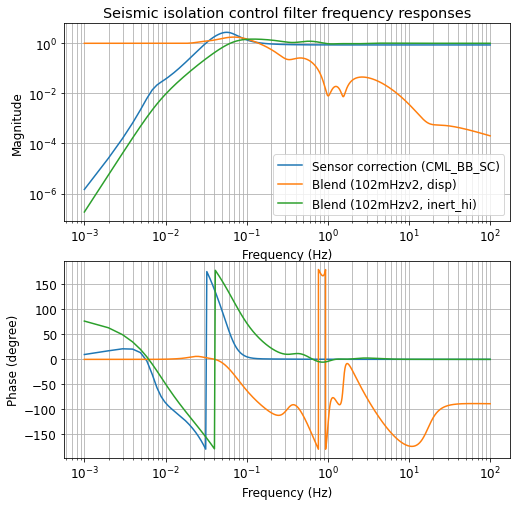

In [174]:
plt.figure(figsize=(8, 8))
plt.rcParams.update({"font.size": 12})
plt.subplot(211)
plt.title("Seismic isolation control filter frequency responses")
plt.loglog(f, abs(h_sc(1j*2*np.pi*f)), label="Sensor correction (CML_BB_SC)")
plt.loglog(f, abs(h1(1j*2*np.pi*f)), label="Blend (102mHzv2, disp)")
plt.loglog(f, abs(h2(1j*2*np.pi*f)), label="Blend (102mHzv2, inert_hi)")

plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.legend(loc=0)
plt.grid(which="both")

plt.subplot(212)
plt.semilogx(f, np.angle(h_sc(1j*2*np.pi*f), deg=True))
plt.semilogx(f, np.angle(h1(1j*2*np.pi*f), deg=True), label="Blend (102mHzv2, disp)")
plt.semilogx(f, np.angle(h2(1j*2*np.pi*f), deg=True), label="Blend (102mHzv2, inert_hi)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Phase (degree)")
# plt.legend(loc=0)
plt.grid(which="both")

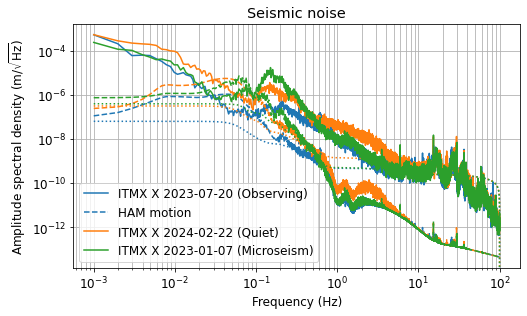

In [217]:
plt.figure(figsize=(8, 4.5))
plt.title("Seismic noise")
plt.rcParams.update({'font.size': 12})

plt.loglog(f, seis_x2, label="ITMX X 2023-07-20 (Observing)")
# plt.loglog(f, noise_model(f, *n_seis_params2), "C0--")
# plt.loglog(f, xg2)
# plt.loglog(f, n_sc2, "C0-.")
# plt.loglog(f, n_rel_sc2, "C0:")
plt.loglog(f, n_super2, "C0--", label="HAM motion")
plt.loglog(f, asd2, "C0:")

plt.loglog(f, seis_x1, label="ITMX X 2024-02-22 (Quiet)")
# # plt.loglog(f, n_seis1(f), "C1--")
# # plt.loglog(f, xg1)
# plt.loglog(f, n_sc1, "C1-.")
# plt.loglog(f, n_rel_sc1, "C1:")
plt.loglog(f, n_super1, "C1--")
plt.loglog(f, asd1, "C1:")


# plt.loglog(f, seis_x3, label="ITMX X 2024-01-01 (Earthquake)")

plt.loglog(f, seis_x4, label="ITMX X 2023-01-07 (Microseism)")
# # plt.loglog(f, noise_model(f, *n_seis_params4), "C2--")
# # plt.loglog(f, xg4)
# plt.loglog(f, n_sc4, "C2-.")
# plt.loglog(f, n_rel_sc4, "C2:")
plt.loglog(f, n_super4, "C2--")
plt.loglog(f, asd4, "C2:")

# plt.loglog(f, seis_x5, label="ITMX X 2023-01-12 (?)")

# plt.loglog(ade1_freq_data, ade1_noise_data)
# plt.loglog(f, noise_model(f, *n_ade1_params), "C3--")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude spectral density ($\mathrm{m}/\sqrt{\mathrm{Hz}}$)")
plt.legend(loc=0)
plt.grid(which="both")

In [213]:
# asd1 = kontrol.spectral.asd2rms(f=f, asd=n_super1*2*np.pi*f)
# asd2 = kontrol.spectral.asd2rms(f=f, asd=n_super2*2*np.pi*f)
# asd4 = kontrol.spectral.asd2rms(f=f, asd=n_super4*2*np.pi*f)